# DALL-E

This notebook gives examples of using each of the endpoints in the DALL-E API Private Preview

Currently these consist of:
- **Generation:** An API that allows you to generate an image or images with a supplied caption
- **Edits:** An API that alows you to edit or extend an existing image
- **Variations:** An API that generates variations of a supplied image

## Setup

Here we perform the following steps:
- Import the packages we need
- Import OpenAI API key
- Set urls for DALL-E endpoints

In [1]:
%load_ext autoreload
%autoreload 

In [10]:
import openai
import requests
import os
from IPython.display import Image

openai.api_key = os.environ.get('OPENAI_API_KEY')

In [3]:
# Set the urls for our API endpoints

dalle_generation_url = 'https://api.openai.com/v1/images/generations'
dalle_variations_url = 'https://api.openai.com/v1/images/variations'

# To be added later
dalle_edits_url = 'https://api.openai.com/v1/images/edits'

In [4]:
# Set a directory to write our dalle images to

image_dir = os.path.join(os.curdir,'images')

## Generation

This is the base endpoint for DALLE and allows you to generate an image with a given caption

**Required:**
- caption: str describing the desired image

**Optional:**
- model: str ID of the model to use.
- num_images: 1-10 generated images
- size: The size of image to generate 64x64, 256x256 or 1024x1024. Smaller images are faster to generate.
- response_format:"url" or b64_json

In [5]:
generation_headers = {
            "Authorization": f"Bearer {openai.api_key}",
            "Content-Type": "application/json"
        }

In [6]:
def generate_images(generation_headers,caption,model="image-alpha-001",num_images=1,size="1024x1024",response_format='url'):
    generation_json = {
                          "model": model,
                          "caption": caption,
                          "num_images": num_images,
                          "size":size , 
                          "response_format": response_format
                        }
    
    response = requests.post(dalle_generation_url,headers=generation_headers,json=generation_json)
    
    return response

In [7]:
image_gen_response = generate_images(generation_headers,"A monkey hacker dreaming of beautiful bananas, cyberpunk style").json()

In [8]:
generated_image = requests.get(image_gen_response['data'][0]['url']).content
with open(os.path.join(image_dir,'image_name.png'), 'wb') as handler:
    handler.write(generated_image)

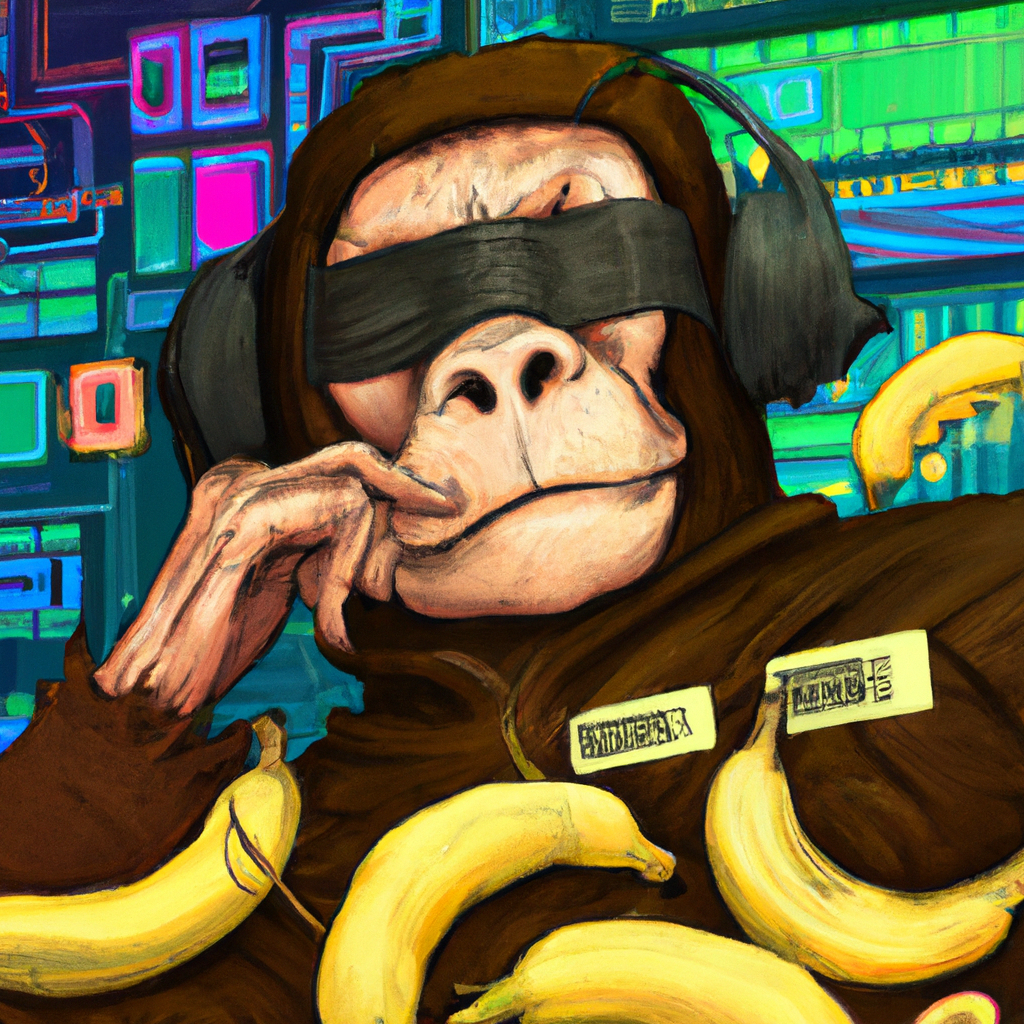

In [11]:
Image(os.path.join(image_dir,'image_name.png'))

## Variations

Here we use the image generated in the previous step to generate a bunch of variations using the DALLE API

**Required:**
- image: The image for variations in binary format

**Optional:**
- model: str ID of the model to use.
- num_images: 1-10 generated variations of the original image
- size: The size of image to generate 64x64, 256x256 or 1024x1024. Smaller images are faster to generate.
- response_format: url, b64_json


In [12]:
variation_headers = {
            "Authorization": f"Bearer {openai.api_key}"
        }

image_path = os.path.join(image_dir,'image_name.png')

In [13]:
def generate_variations(headers
                        ,image_path
                        ,model="image-alpha-001"
                        ,size="1024x1024"
                        ,num_images=5
                        ,response_format="url"):
    variation_files = {
    "image": open(image_path, 'rb'),
    }

    variation_body = {
        "model": model,
        "size": size,
        "num_images": num_images,
        "response_format": response_format
    }
    variations_response = requests.post(dalle_variations_url,headers=headers,data=variation_body,files=variation_files)
    
    return variations_response

In [15]:
variations_response = generate_variations(headers=variation_headers,image_path=image_path)

In [16]:
image_variation_list = variations_response.json()['data']
counter = 0
for image_variation in image_variation_list:
    counter += 1
    url_image = requests.get(image_variation['url']).content
    with open(os.path.join(image_dir,f'edited_monkey_hacker_{counter}.png'), 'wb') as handler:
        handler.write(url_image)

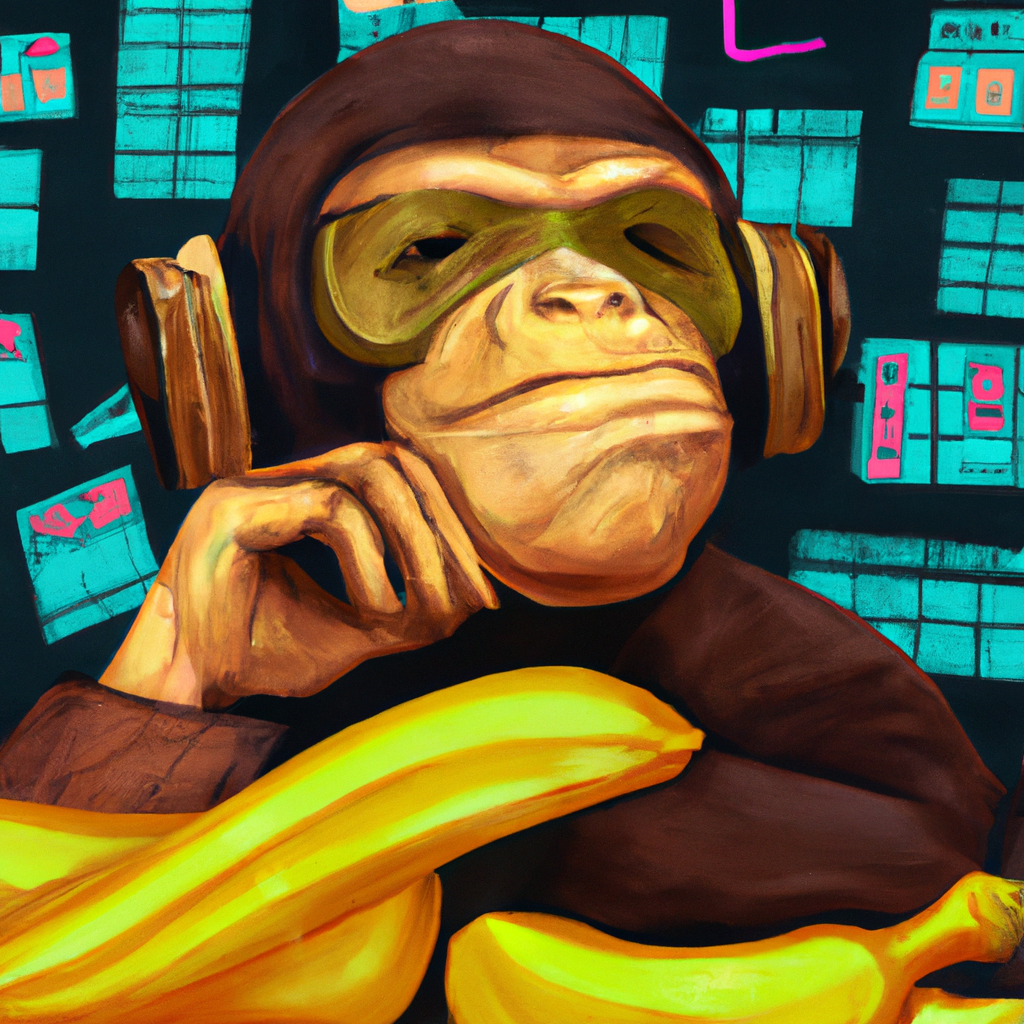

In [18]:
Image(os.path.join(image_dir,'edited_monkey_hacker_1.png'))

## Edits

The edit function allows you to have DALL-E generate new variations for a part of an existing image. This is done using a "mask" to set the part of the original image that you want edited, along with the entire image and a caption

**Required params:** 
- caption: str describing the desired image.
- image: The image for editing in binary format
- mask: The mask for editing as a JSON serialized encoded numpy array.

**Optional params:**
- model: str ID of the model to use.
- num_images: 1-10 generated images
- size: The size of image to generate 64x64, 256x256 or 1024x1024. Smaller images are faster to generate.
- Response_format: url, b64_json


### Set Edit Area

To perform an edit you need a "mask", which is a JSON serialised numpy array representation of your original image with pixels that you want to be edited replaced with 0.

To do this we'll follow these steps:
- Set a pixel value, under which we'll set all pixels to 0
- Read in our image
- Create a masked_image with our masking logic applied
- Plot this to confirm our masking worked

In [57]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

pixel_value = 100  #Value in range 0 to 255

image = imageio.imread("./monkey_hacker.png")

# Screen out pixels under the pixel value set above
mask_pixels = image >= pixel_value
image_masked = np.where(mask_pixels,image,0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


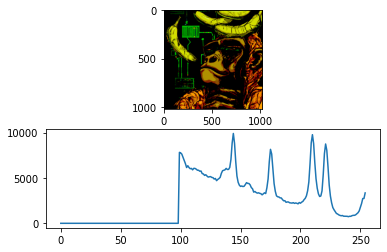

In [69]:
# Import SciPy's "ndimage" module
import scipy.ndimage as ndi

# Get the histogram of pixels to confirm that our where clause worked
hist = ndi.histogram(image_masked, min=1, max=255, bins=255)

# Plot masked image and histogram
fig, axes = plt.subplots(2,1)
axes[0].imshow(image_masked)
axes[1].plot(hist)

In [77]:
import numpy
from json import JSONEncoder
import json

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

# Serialization

print("serialize NumPy array into JSON and write into a file")
with open("numpyData.png", "w") as write_file:
    json.dump(image_masked, write_file, cls=NumpyArrayEncoder)
print("Done writing serialized NumPy array into file")

serialize NumPy array into JSON and write into a file
Done writing serialized NumPy array into file


### Perform Edit

Now we supply our image, caption and mask to the API to get a response

In [78]:
edit_headers = {
            "Authorization": f"Bearer {OPENAI_API_KEY}"
    #,"Content-Type": 'application/json'#"multipart/form-data"
        }

edit_image_path = './monkey_hacker.png'
edit_mask_path = './numpyData.png'

In [79]:
def generate_edits(headers
                        ,caption
                        ,image_path
                        ,mask_path
                        ,model="image-alpha-001"
                        ,size="1024x1024"
                        ,num_images=5
                        ,response_format="url"):
    edit_files = {
    "image": open(edit_image_path, 'rb'),
    "mask": open(edit_mask_path, 'rb'),
    }

    edit_body = {
        "caption": caption,
        "model": model,
        "size": size,
        "num_images": num_images,
        "response_format": response_format
    }
    edit_response = requests.post(dalle_edits_url,headers=headers,data=edit_body,files=edit_files)
    
    return edit_response

In [80]:
edit_response = generate_edits(headers=edit_headers,caption='A field of computers made of bananas, modern art',image_path=edit_image_path,mask_path=edit_mask_path)

In [81]:
edit_response.json()

{'error': {'code': None,
  'message': 'The server had an error while processing your request. Sorry about that!',
  'param': None,
  'type': 'server_error'}}